In [1]:
#环境配置
import cv2
import sys
import json
import numpy as np
from os.path import join, isdir
from IPython.display import clear_output, Image, display, HTML
import time
import ipywidgets as widgets
import kcftracker

In [2]:
#读取dataset和配置文件
dataset = "OTB100"
base_path = join(dataset)
json_path = join(dataset + '.json')
annos = json.load(open(json_path, 'r'))


In [3]:
#选择测试用的序列
testvideo = ['dog']
# 可以从下面任意选择放入testvideo中
# ['basketball','biker','bird1','bird2','blurBody','blurCar1','blurCar2','blurCar3','blurCar4','blurFace','blurOwl','board','bolt',
#  'bolt2','box','boy','car1','car2','car24','car4','carDark','carScale','clifBar','coke','couple','coupon','crossing','crowds','dancer','dancer2',
#  'david','david2','david3','deer','diving','dog','dog1','doll','dragonBaby','dudek','faceocc1','faceocc2','fish','fleetface','football','football1','freeman1',
#  'freeman3' 'freeman4','girl','girl2','gym','human2','human3','human4_2','human5','human6','human7','human8','human9','ironman','jogging_1','jogging_2','jump',
#  'jumping','kiteSurf', 'lemming','liquor','man','matrix','mhyang','motorRolling','mountainBike','panda','redTeam','rubik','shaking','singer1','singer2',
#  'skater','skater2', 'skating1','skating2_1','skating2_2','skiing','soccer','subway','surfer','suv','sylvester','tiger1','tiger2','toy','trans','trellis','twinnings','vase','walking','walking2','woman']
# 
#初始化kcftracker
tracker = kcftracker.KCFTracker(True, True, True) 

In [4]:
#测试KCF Tracker
for video_id, video in enumerate(testvideo):  
        video_path_name = annos[video]['name'] #获取视频名称
        init_rect = np.array(annos[video]['init_rect']) #获取初始帧的bounding box
        image_files = [join(base_path, video_path_name, 'img', im_f) for im_f in annos[video]['image_files']] #获取视频中所有图片的路径
        n_images = len(image_files)#获取视频长度

        
        first_im = cv2.imread(image_files[0])  # 读取图片
        tracker.init(init_rect,first_im) #利用初始图像和boundingbox初始化跟踪器
        
        imgbox = widgets.Image(format='jpg', height=first_im.shape[0], width=first_im.shape[1]) #创建图片展示套件
        display(imgbox)
        
        
        for count in range(1 , n_images):
            
            gt = annos[video]['gt_rect'][count] #获取gt
            img = cv2.imread(image_files[count])#读取图片
            
            boundingbox = tracker.update(img)#获取计算得到的boundingbox
            boundingbox = list(map(int, boundingbox))#将boundingbox中的数字转为int
            
            #绘制预测的boundingbox 框颜色为红色
            cv2.rectangle(img, (boundingbox[0],boundingbox[1]), (boundingbox[0]+boundingbox[2],boundingbox[1]+boundingbox[3]),(0,0,255), 3)
            #绘制groudtruth作为对比 框颜色为绿色
            cv2.rectangle(img, (gt[0],gt[1]), (gt[0]+gt[2],gt[1]+gt[3]),(0, 255, 0), 3)
            
            #图像更新
            imgbox.value = cv2.imencode('.jpg', img)[1].tobytes()

Image(value=b'', format='jpg', height='240', width='352')

In [5]:
#计算两个boundingbox的中心点偏移，bbox均为ltwh模式
def compute_center_error(bbox1,bbox2):
    cen1 = np.array([bbox1[0]+bbox1[2]-1/2,bbox1[1]+bbox1[3]-1/2])
    cen2 = np.array([bbox2[0]+bbox2[2]-1/2,bbox2[1]+bbox2[3]-1/2])
    errors = np.sqrt(np.sum(np.power(cen1 - cen2, 2)))
    return errors

#计算两个boundingbox的iou bbox均为ltwh模式
def compute_iou(bbox1,bbox2):
    l1, t1, r1, d1 = bbox1[0], bbox1[1], bbox1[0]+bbox1[2], bbox1[1]+bbox1[3]
    l2, t2, r2, d2 = bbox2[0], bbox2[1], bbox2[0]+bbox2[2], bbox2[1]+bbox2[3]
    l = max(l1,l2)
    t = max(t1,t2)
    r = min(r1,r2)
    d = min(d1,d2)
    innerarea = (r - l)*(d - t)
    if (r - l) <= 0 or (d - t)<=0:
        return 0.0
    outarea1 = bbox1[2] * bbox1[3]
    outarea2 = bbox2[2] * bbox2[3]
    return innerarea/(outarea1+outarea2-innerarea)

#储存dict函数
def jsonsave(filename,file):
    with open(filename, 'w') as f_obj:
        json.dump(file, f_obj)

In [6]:
#计算在OTB上KCF跟踪算法的效果
evaluate_save = dict()

#用于存储每个视频的iou和center_error平均值
iou_means = []
center_error_means = []
#选取6个视频作为评价指标
videos =['blurCar1','basketball','skater2','sylvester','trellis','freeman3']
for name in videos:
    #视频名
    video_path_name = annos[name]['name']
    #图像名
    imgs_name = annos[name]['image_files']
    #groundtruth
    imgs_gt = annos[name]['gt_rect']
    #初始groudtruth
    init_rect = annos[name]['init_rect']
    #视频路径
    image_files = [join(base_path, video_path_name, 'img', im_f) for im_f in imgs_name]
    
    first_image = cv2.imread(image_files[0])
    imgbox = widgets.Image(format='jpg', height=first_image.shape[0], width=first_image.shape[1]) #创建图片展示套件
    display(imgbox)
   
    #初始化tracker
    tracker.init(init_rect,first_image)
    
    #存放每一帧的iou
    video_ious = []
    #存放每一帧的中心坐标差
    video_center_errors = []
    
    
    for num , path_name in enumerate(image_files[1:]):
        im = cv2.imread(path_name)
        boundingbox = tracker.update(im)
        gt = imgs_gt[num+1]
  
        #OTB部分gt有误，跳过
        if imgs_gt[num+1][2]==0 or imgs_gt[num+1][3]==0:
            continue
            
            
        #计算iou
        iou = compute_iou(boundingbox,gt)
        #计算center_error
        center_error = compute_center_error(boundingbox,gt)
                      #             # 跟踪框绘制
        res = [int(l) for l in boundingbox]
        cv2.rectangle(im, (res[0], res[1]), (res[0] + res[2], res[1] + res[3]), (0, 255, 255), 3)
        cv2.rectangle(im, (imgs_gt[num+1][0], imgs_gt[num+1][1]), (imgs_gt[num+1][0] + imgs_gt[num+1][2], imgs_gt[num+1][1] + imgs_gt[num+1][3]), (255, 0, 0), 3)
        cv2.putText(im, str(iou), (40, 40), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 255), 2, cv2.LINE_AA)
        #
        #             # 显示跟踪结果
        imgbox.value = cv2.imencode('.jpg', im)[1].tobytes()
        cv2.waitKey(1)

        #储存iou与center_error
        video_ious.append(iou)
        video_center_errors.append(center_error)
    
    #计算iou和中心偏差的平均值
    iou_mean = np.mean(np.array(video_ious))
    center_error_mean = np.mean(np.array(video_center_errors))
    #存储
    evaluate_save[name]={
                "name":video_path_name,
                "video_ious":video_ious,
                "iou_mean":iou_mean,
                "video_center_errors":video_center_errors,
                "center_error_mean":center_error_mean
           }
    
    iou_means.append(iou_mean)
    center_error_means.append(center_error_mean)
    print("video_name:{},  avg_iou:{}%, avg_center_error:{}".format(video_path_name,(iou_mean*100),center_error_mean))

#计算在所有视频中iou和中心偏差的平均值
total_iou_mean = np.mean(np.array(iou_means))
total_center_error_mean = np.mean(np.array(center_error_means))
print("total_avg_iou:{}%, total_avg_center_error:{}".format((total_iou_mean*100),total_center_error_mean))
#储存计算结果
jsonsave("OTB_evaluate_save.json",evaluate_save)

Image(value=b'', format='jpg', height='480', width='640')

video_name:BlurCar1,  avg_iou:41.48369344319235%, avg_center_error:63.16077480969964


Image(value=b'', format='jpg', height='432', width='576')

video_name:Basketball,  avg_iou:41.71576792492228%, avg_center_error:34.34113354769588


Image(value=b'', format='jpg', height='262', width='320')

video_name:Skater2,  avg_iou:57.947580218349046%, avg_center_error:16.429701875244593


Image(value=b'', format='jpg', height='240', width='320')

video_name:Sylvester,  avg_iou:48.87189434585061%, avg_center_error:30.793937144956317


Image(value=b'', format='jpg', height='240', width='320')

video_name:Trellis,  avg_iou:79.37659357820131%, avg_center_error:5.625375227933234


Image(value=b'', format='jpg', height='240', width='360')

video_name:Freeman3,  avg_iou:77.10462137658222%, avg_center_error:2.2328350670329296
total_avg_iou:57.75002514784964%, total_avg_center_error:25.430626278760432


In [7]:
#绘制iou和中心点误差图

import matplotlib.pyplot as plt
from scipy.interpolate import make_interp_spline
#读取刚才计算的结果
annos = json.load(open("OTB_evaluate_save.json", 'r'))

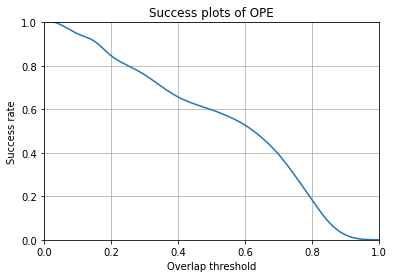

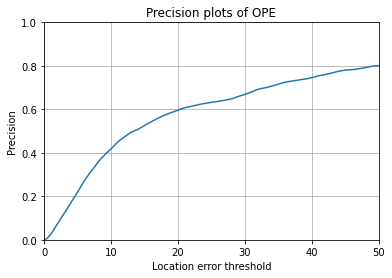

In [8]:
#################绘制video_ious#########################
al = []
al = np.array(al)
for i in annos:
    al = np.append(al , annos[i]["video_ious"])
al = np.ndarray.flatten(al)
X = np.linspace(0, 1, 21, endpoint=True)
Y = np.zeros([21])
plt.axis([0,1,0,1])

for i in range(21):
        Y[i] = np.size(np.where(al>=X[i]))/np.size(al)

x_smooth = np.linspace(X.min(),X.max(),300) #300 represents number of points to make between T.min and T.max
# power_smooth = make_interp_spline(x_suc,L,xnew)
y_smooth = make_interp_spline(X,Y)(x_smooth)
# 加网格线
plt.grid()
# 标题 横纵坐标名
plt.title(u"Success plots of OPE")
plt.xlabel(u"Overlap threshold")
plt.ylabel(u"Success rate")

plt.plot(x_smooth,y_smooth)
plt.show()
##############################绘制video_center_errors##########################
al = []
al = np.array(al)
for i in annos:
    al = np.append(al , annos[i]["video_center_errors"])
al = np.ndarray.flatten(al)
X = np.linspace(0, 50, 51, endpoint=True)
Y = np.zeros([51])
plt.axis([0,50,0,1])

for i in range(51):
        Y[i] = np.size(np.where(al<=X[i]))/np.size(al)

x_smooth = np.linspace(X.min(),X.max(),300) #300 represents number of points to make between T.min and T.max
# power_smooth = make_interp_spline(x_suc,L,xnew)
y_smooth = make_interp_spline(X,Y)(x_smooth)
# 加网格线
plt.grid()
# 标题 横纵坐标名
plt.title(u"Precision plots of OPE")
plt.xlabel(u"Location error threshold")
plt.ylabel(u"Precision")

plt.plot(x_smooth,y_smooth)
plt.show()
